In [118]:
from math import sqrt
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb

pd.set_option('display.max_rows', 500)


# LSTM libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L

In [2]:
# train_data = pd.read_csv("../data/processed/train_preprocessed.csv")
# test_data = pd.read_csv("../data/processed/test_preprocessed.csv")
# validation_data = pd.read_csv("../data/processed/validate_preprocessed.csv")

In [3]:
# train_data.head(6)

In [4]:
def prepare_time_series_data(df: pd.DataFrame, n: int, target_column: str) -> pd.DataFrame:
    """
    Prepares time series data using the last n timestamps and the current timestamp
    to predict the target column.

    Args:
    - df (pd.DataFrame): The input data containing timestamps and feature columns.
    - n (int): The number of previous timestamps to use as features.
    - target_column (str): The name of the target column.

    Returns:
    - pd.DataFrame: A DataFrame where each row contains n+1 timestamps of features and the target value.
    """
    feature_columns = [col for col in df.columns if col != target_column and col != 'time']
    data = []
    columns = []

    # Generate column names for the reorganized DataFrame
    for i in range(n, 0, -1):
        columns += [f"{col}_t-{i}" for col in feature_columns]
    columns += [f"{col}_t" for col in feature_columns]  # Add current timestep features
    columns += [target_column]

    # Populate the rows with shifted data
    for i in tqdm(range(n, len(df)),
            desc="Preparing time series data",
            total=len(df),
            unit=" rows"
            ):
        row_features = df.iloc[i-n:i][feature_columns].values.flatten()  # Last n timesteps
        current_features = df.iloc[i][feature_columns].values  # Current timestep
        row_target = df.iloc[i][target_column]  # Target value
        data.append(list(row_features) + list(current_features) + [row_target])
    
    return pd.DataFrame(data, columns=columns)

In [5]:
# prepared_train_data = prepare_time_series_data(train_data, 6, 'target')
prepared_train_data = pd.read_csv("../data/processed/series_train_preprocessed.csv")

In [6]:
# prepared_test_data = prepare_time_series_data(test_data, 6, 'target')
prepared_test_data = pd.read_csv("../data/processed/series_test_preprocessed.csv")

In [7]:
# prepared_validation_data = prepare_time_series_data(validation_data, 6, 'target')
prepared_validation_data = pd.read_csv("../data/processed/series_validate_preprocessed.csv")

In [8]:
# prepared_train_data.to_csv("../data/processed/series_train_preprocessed.csv", index=False)
# prepared_test_data.to_csv("../data/processed/series_test_preprocessed.csv", index=False)
# prepared_validation_data.to_csv("../data/processed/series_validate_preprocessed.csv", index=False)

In [9]:
X_train = prepared_train_data.drop('target', axis=1)
y_train = prepared_train_data['target']

X_test = prepared_test_data.drop('target', axis=1)
y_test = prepared_test_data['target']

X_val = prepared_validation_data.drop('target', axis=1)
y_val = prepared_validation_data['target']

#### Base models for Feature importance


##### Random Forest Regressor

In [10]:
# Train a Random Forest Regressor
# Initialize the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,         # Number of trees in the forest
    max_depth=15,             # Maximum depth of each tree
    min_samples_split=10,     # Minimum samples required to split an internal node
    min_samples_leaf=4,       # Minimum samples required to be at a leaf node
    max_features='sqrt',      # Number of features to consider for best split
    bootstrap=True,           # Whether to use bootstrap samples
    n_jobs=-1,                # Use all available CPU cores
    random_state=42           # For reproducibility
)


In [11]:
# train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_jobs=-1, random_state=42)

In [12]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [13]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Random Forest MSE: {mse}")

Random Forest MSE: 2.7640253188744966e-06


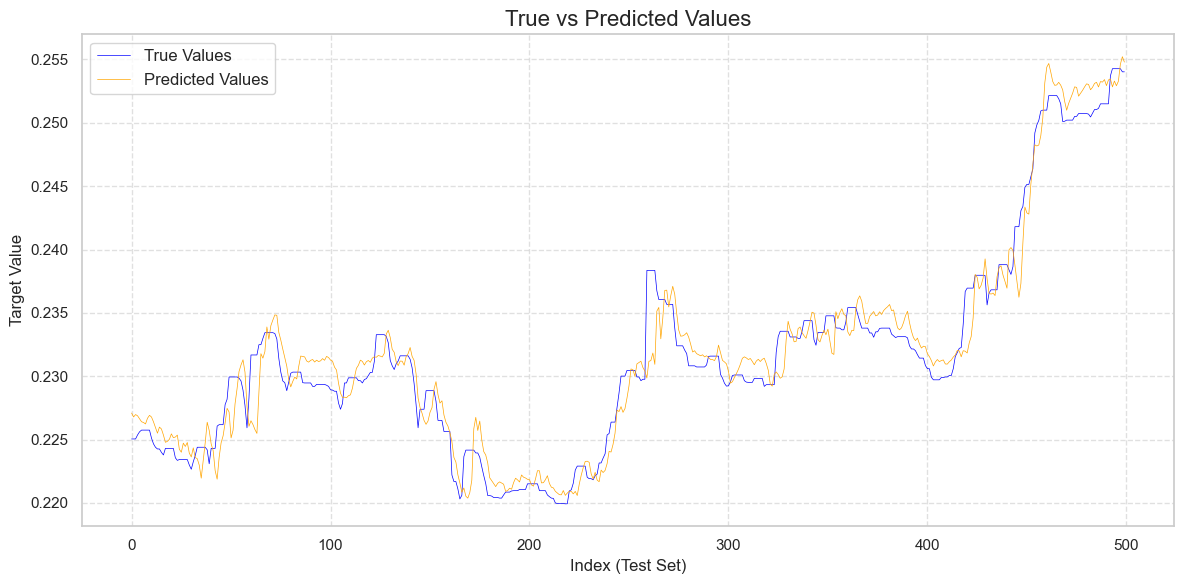

In [14]:
# plot y_test vs y_pred
# Plot the true and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label='True Values', color='blue', linewidth=0.5)
plt.plot(y_pred[:500], label='Predicted Values', color='orange', linewidth=0.5)

# Add titles and labels
plt.title('True vs Predicted Values', fontsize=16)
plt.xlabel('Index (Test Set)', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

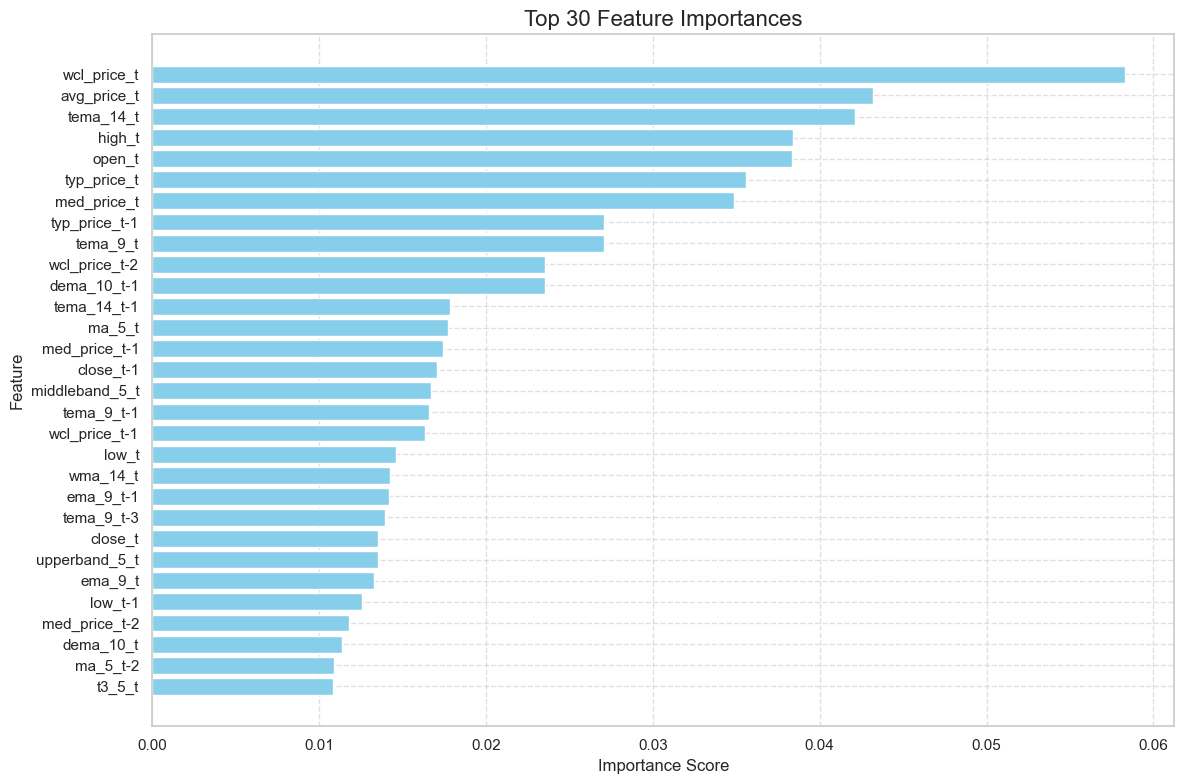

In [15]:
# plot the feature importances
# Get feature importances and their corresponding feature names
rf_feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort the features by importance
sorted_idx = np.argsort(rf_feature_importances)[::-1]
rf_sorted_importances = rf_feature_importances[sorted_idx]
rf_sorted_features = feature_names[sorted_idx]

# Plot the feature importances
top_n = 30
plt.figure(figsize=(12, 8))
plt.barh(rf_sorted_features[:top_n][::-1], rf_sorted_importances[:top_n][::-1], color='skyblue')  # Top 20 features
plt.title(f'Top {top_n} Feature Importances', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


In [16]:
idx = 0
for i, j in zip(rf_sorted_features, rf_sorted_importances):
    idx += 1
    if "sentiment" in i:
        print(i, idx, j)

sentiment_score_t-5 481 1.1991802169263263e-07
sentiment_score_t-1 543 1.027066718954716e-07
sentiment_score_t-3 560 9.757561830793035e-08
sentiment_score_t-4 564 9.676289946753713e-08
sentiment_score_t 589 9.040236482640942e-08
sentiment_score_t-6 599 8.90079920376474e-08
sentiment_score_t-2 609 8.835104779413354e-08


In [17]:
rf_sorted_features[30]

'avg_price_t-1'

##### XGBoost Regressor

In [18]:
# Train a XGBoost Regressor
# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=500,           # Number of trees
    learning_rate=0.1,          # Step size for weight updates
    max_depth=6,                # Depth of each tree
    min_child_weight=10,        # Minimum sum of weights in child nodes
    subsample=0.8,              # Subsample ratio for training data
    colsample_bytree=0.8,       # Subsample ratio for features
    gamma=0,                    # Minimum loss reduction for further partitioning
    reg_alpha=0.1,              # L1 regularization (prevents overfitting)
    reg_lambda=1.0,             # L2 regularization (prevents overfitting)
    random_state=42,            # Ensures reproducibility
    tree_method='hist',         # Faster tree construction for large datasets
    n_jobs=-1,                  # Use all available CPU threads
    early_stopping_rounds=10
)

In [19]:
# Train the model
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10)


[0]	validation_0-rmse:0.16944
[10]	validation_0-rmse:0.05926
[20]	validation_0-rmse:0.02088
[30]	validation_0-rmse:0.00782
[40]	validation_0-rmse:0.00386
[50]	validation_0-rmse:0.00302
[60]	validation_0-rmse:0.00289
[70]	validation_0-rmse:0.00287
[80]	validation_0-rmse:0.00286
[90]	validation_0-rmse:0.00286
[100]	validation_0-rmse:0.00285
[110]	validation_0-rmse:0.00285
[120]	validation_0-rmse:0.00285
[130]	validation_0-rmse:0.00285


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [20]:
# Make predictions
y_pred = xgb_model.predict(X_test)

In [21]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"XGBoost MSE: {mse}")

XGBoost MSE: 2.4673402378740997e-06


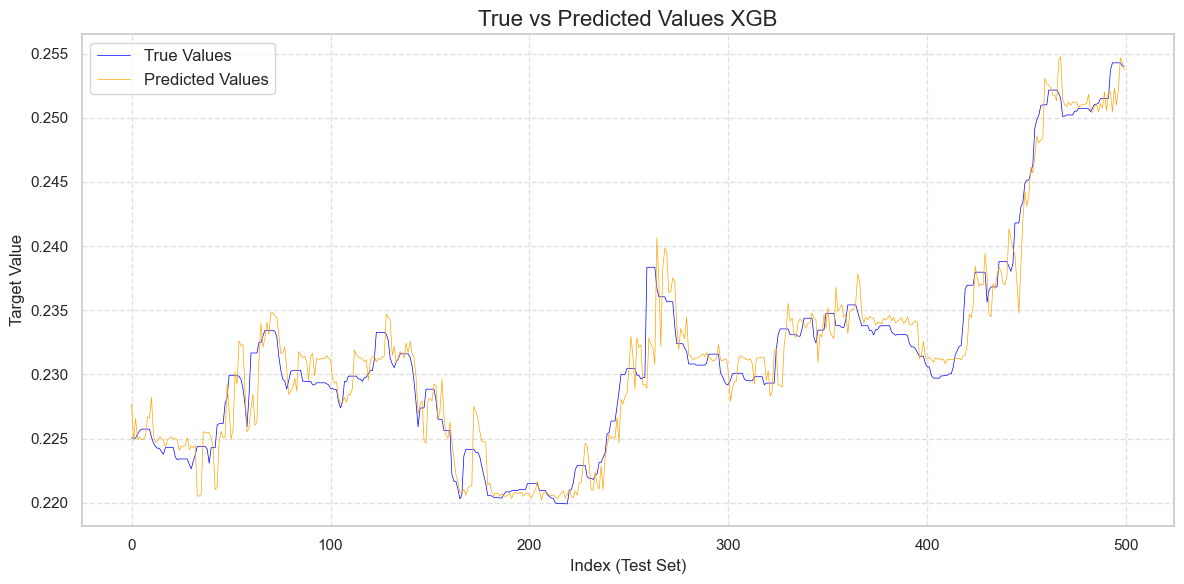

In [22]:
# plot y_test vs y_pred
# Plot the true and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label='True Values', color='blue', linewidth=0.5)
plt.plot(y_pred[:500], label='Predicted Values', color='orange', linewidth=0.5)

# Add titles and labels
plt.title('True vs Predicted Values XGB', fontsize=16)
plt.xlabel('Index (Test Set)', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

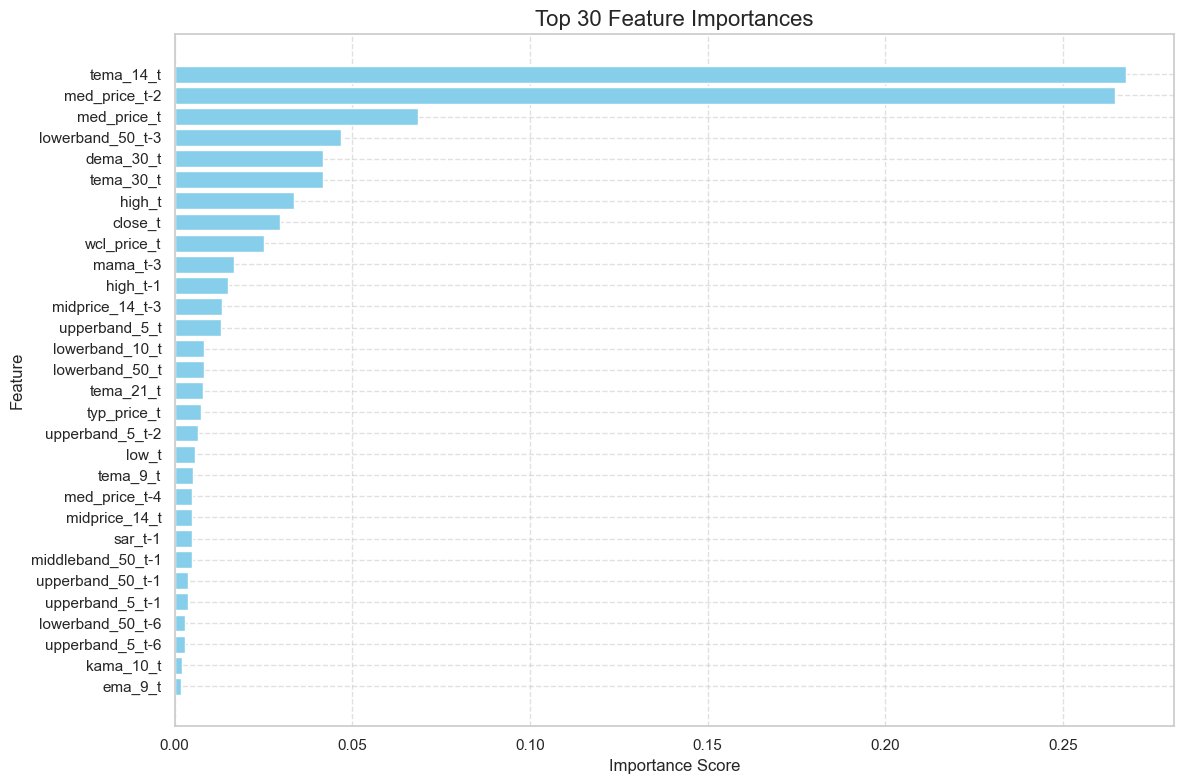

In [23]:
# plot the feature importances
# Get feature importances and their corresponding feature names
xgb_feature_importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Sort the features by importance
sorted_idx = np.argsort(xgb_feature_importances)[::-1]
xgb_sorted_importances = xgb_feature_importances[sorted_idx]
xgb_sorted_features = feature_names[sorted_idx]

# Plot the feature importances
top_n = 30
plt.figure(figsize=(12, 8))
plt.barh(xgb_sorted_features[:top_n][::-1], xgb_sorted_importances[:top_n][::-1], color='skyblue')  # Top 20 features
plt.title(f'Top {top_n} Feature Importances', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
idx = 0
for i, j in zip(xgb_sorted_features, xgb_sorted_importances):
    idx += 1
    if "sentiment" in i:
        print(i, idx, j)

sentiment_score_t 193 5.9050876e-07
sentiment_score_t-6 217 4.3983712e-07
sentiment_score_t-1 252 3.4315335e-07
sentiment_score_t-5 285 2.5283745e-07
sentiment_score_t-4 287 2.506846e-07
sentiment_score_t-3 288 2.4789972e-07
sentiment_score_t-2 307 2.2035714e-07


##### LightGBM Regressor

In [25]:
# Train a Light GBM 
# Define initial LightGBM parameters
params = {
    "boosting_type": "gbdt",           # Gradient Boosting Decision Tree
    "objective": "regression",         # Regression task
    "metric": "rmse",                  # Root Mean Squared Error for evaluation
    "num_leaves": 31,                  # Maximum number of leaves in one tree
    "learning_rate": 0.05,             # Lower learning rate with more boosting rounds
    "feature_fraction": 0.8,           # Percentage of features used per tree
    "bagging_fraction": 0.8,           # Percentage of data used per tree
    "bagging_freq": 5,                 # Perform bagging every 5 iterations
    "max_depth": -1,                   # No maximum depth restriction
    "lambda_l1": 0.1,                  # L1 regularization
    "lambda_l2": 0.2,                  # L2 regularization
    "verbosity": -1,                   # Suppress output
    "n_jobs": -1,                      # Use all CPU cores
    "seed": 42,                        # Seed for reproducibility
    "early_stopping_rounds": 10,       # Stop if no improvement in 10 rounds
    "verbose_eval": 10                 # Print evaluation results every 10 rounds
}

In [26]:
# Convert training data into LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [27]:
# Train the model
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,              # Maximum boosting iterations
    valid_sets=[train_data, valid_data],
)

In [28]:
# Make predictions
y_pred = lgb_model.predict(X_test)

In [29]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"LightGBM MSE: {mse}")

LightGBM MSE: 2.667824664104948e-06


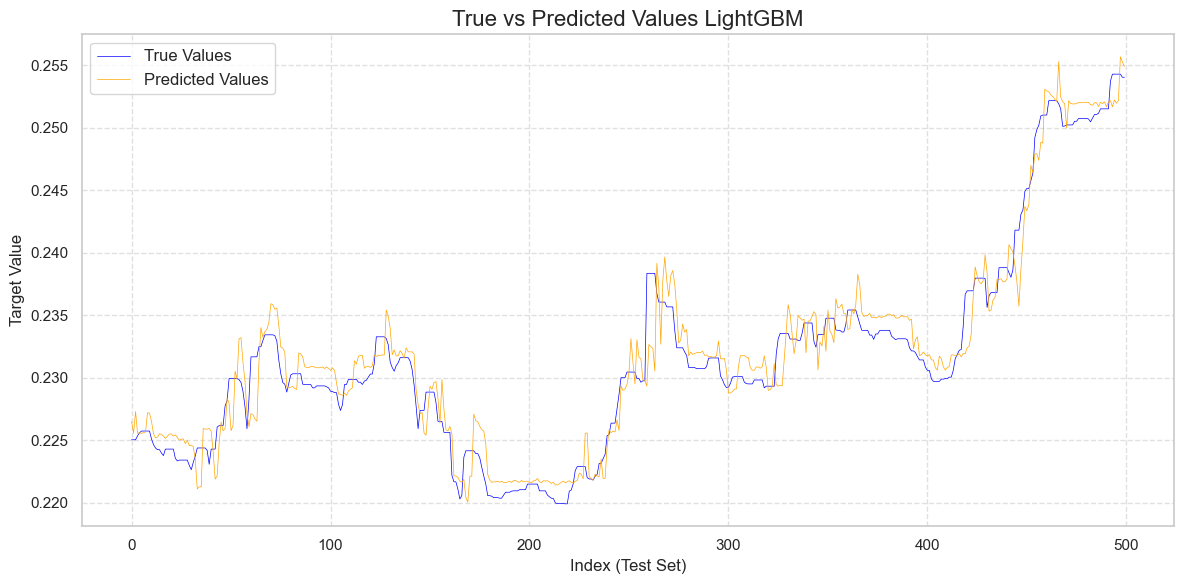

In [30]:
# plot y_test vs y_pred
# Plot the true and predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test[:500], label='True Values', color='blue', linewidth=0.5)
plt.plot(y_pred[:500], label='Predicted Values', color='orange', linewidth=0.5)

# Add titles and labels
plt.title('True vs Predicted Values LightGBM', fontsize=16)
plt.xlabel('Index (Test Set)', fontsize=12)
plt.ylabel('Target Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

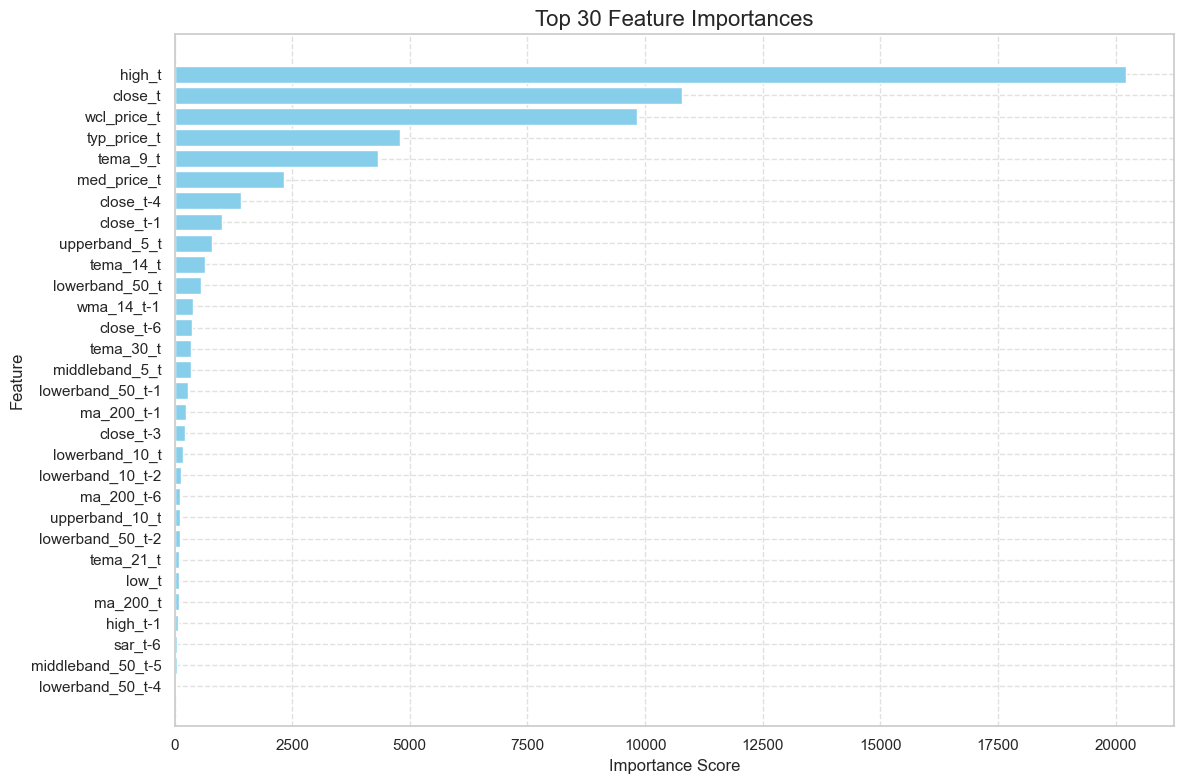

In [31]:
# plot the feature importances
# Get feature importances and their corresponding feature names
lgb_feature_importances = lgb_model.feature_importance(importance_type="gain")  # Use "split" for split count
feature_names = X_train.columns

# Sort the features by importance
sorted_idx = np.argsort(lgb_feature_importances)[::-1]
lgb_sorted_importances = lgb_feature_importances[sorted_idx]
lgb_sorted_features = feature_names[sorted_idx]

# Plot the feature importances
top_n = 30
plt.figure(figsize=(12, 8))
plt.barh(lgb_sorted_features[:top_n][::-1], lgb_sorted_importances[:top_n][::-1], color='skyblue')  # Top 20 features
plt.title(f'Top {top_n} Feature Importances', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()


In [32]:
idx = 0
for i, j in zip(lgb_sorted_features, lgb_sorted_importances):
    idx += 1
    if "sentiment" in i:
        print(i, idx, j)

sentiment_score_t-6 186 0.010209967906121165
sentiment_score_t-5 187 0.009853550232946873
sentiment_score_t 224 0.003646032011602074
sentiment_score_t-2 253 0.00212594005279243
sentiment_score_t-4 261 0.0017704290221445262
sentiment_score_t-1 299 0.0008775509777478874
sentiment_score_t-3 879 0.0


#### Top Features

In [39]:
# get set of top 30 features common to all models
all_30 = []
for list in rf_sorted_features[:30], xgb_sorted_features[:30], lgb_sorted_features[:30]:
    all_30.extend(list)
top_features_30 = set(all_30)

# get set of top 20 features common to all models
all_20 = []
for list in rf_sorted_features[:20], xgb_sorted_features[:20], lgb_sorted_features[:20]:
    all_20.extend(list)
top_features_20 = set(all_20)

In [41]:
top_features_30

{'avg_price_t',
 'close_t',
 'close_t-1',
 'close_t-3',
 'close_t-4',
 'close_t-6',
 'dema_10_t',
 'dema_10_t-1',
 'dema_30_t',
 'ema_9_t',
 'ema_9_t-1',
 'high_t',
 'high_t-1',
 'kama_10_t',
 'low_t',
 'low_t-1',
 'lowerband_10_t',
 'lowerband_10_t-2',
 'lowerband_50_t',
 'lowerband_50_t-1',
 'lowerband_50_t-2',
 'lowerband_50_t-3',
 'lowerband_50_t-4',
 'lowerband_50_t-6',
 'ma_200_t',
 'ma_200_t-1',
 'ma_200_t-6',
 'ma_5_t',
 'ma_5_t-2',
 'mama_t-3',
 'med_price_t',
 'med_price_t-1',
 'med_price_t-2',
 'med_price_t-4',
 'middleband_50_t-1',
 'middleband_50_t-5',
 'middleband_5_t',
 'midprice_14_t',
 'midprice_14_t-3',
 'open_t',
 'sar_t-1',
 'sar_t-6',
 't3_5_t',
 'tema_14_t',
 'tema_14_t-1',
 'tema_21_t',
 'tema_30_t',
 'tema_9_t',
 'tema_9_t-1',
 'tema_9_t-3',
 'typ_price_t',
 'typ_price_t-1',
 'upperband_10_t',
 'upperband_50_t-1',
 'upperband_5_t',
 'upperband_5_t-1',
 'upperband_5_t-2',
 'upperband_5_t-6',
 'wcl_price_t',
 'wcl_price_t-1',
 'wcl_price_t-2',
 'wma_14_t',
 'wma_1

In [43]:
top_features_20

{'avg_price_t',
 'close_t',
 'close_t-1',
 'close_t-3',
 'close_t-4',
 'close_t-6',
 'dema_10_t-1',
 'dema_30_t',
 'high_t',
 'high_t-1',
 'low_t',
 'lowerband_10_t',
 'lowerband_10_t-2',
 'lowerband_50_t',
 'lowerband_50_t-1',
 'lowerband_50_t-3',
 'ma_200_t-1',
 'ma_5_t',
 'mama_t-3',
 'med_price_t',
 'med_price_t-1',
 'med_price_t-2',
 'middleband_5_t',
 'midprice_14_t-3',
 'open_t',
 'tema_14_t',
 'tema_14_t-1',
 'tema_21_t',
 'tema_30_t',
 'tema_9_t',
 'tema_9_t-1',
 'typ_price_t',
 'typ_price_t-1',
 'upperband_5_t',
 'upperband_5_t-2',
 'wcl_price_t',
 'wcl_price_t-1',
 'wcl_price_t-2',
 'wma_14_t',
 'wma_14_t-1'}

In [44]:
news_features = [col for col in X_train.columns if "sentiment" in col or "impact" in col]

In [46]:
len(news_features)

14

In [52]:
top_features_20_news = top_features_20.union(news_features)
top_features_30_news = top_features_30.union(news_features)

In [53]:
len(top_features_30_news)

77

In [132]:
rf_top_features = rf_sorted_features[:30].array.tolist()
rf_top_features.extend(news_features)
xgb_top_features = xgb_sorted_features[:30].array.tolist()
xgb_top_features.extend(news_features)
lgb_top_features = lgb_sorted_features[:30].array.tolist()
lgb_top_features.extend(news_features)

# Prepare the data with the top features
X_train_rf_top = X_train[rf_top_features]
X_test_rf_top = X_test[rf_top_features]
X_val_rf_top = X_val[rf_top_features]

X_train_xgb_top = X_train[xgb_top_features]
X_test_xgb_top = X_test[xgb_top_features]
X_val_xgb_top = X_val[xgb_top_features]

X_train_lgb_top = X_train[lgb_top_features]
X_test_lgb_top = X_test[lgb_top_features]
X_val_lgb_top = X_val[lgb_top_features]

In [113]:
y_train.shape

(218543,)

#### LSTM RF Features Regressor

In [130]:
## RF features based LSTM  model
timesteps = 1
features = 30 + len(news_features)
lr = 0.0001  # Learning rate
# Define the model
rf_top_model = Sequential()
rf_top_model.add(L.Bidirectional(L.LSTM(timesteps, activation='tanh', input_shape=(timesteps, features), return_sequences=True)))
rf_top_model.add(L.LSTM(256, activation='tanh', return_sequences=True))
rf_top_model.add(L.LSTM(128, activation='tanh', return_sequences=True))
rf_top_model.add(L.LSTM(64, activation='tanh', return_sequences=False))
rf_top_model.add(L.BatchNormalization())
rf_top_model.add(L.RepeatVector(timesteps))
rf_top_model.add(L.LSTM(timesteps, activation='tanh', return_sequences=True))
rf_top_model.add(L.BatchNormalization())
rf_top_model.add(L.LSTM(64, activation='tanh', return_sequences=True))
rf_top_model.add(L.LSTM(128, activation='tanh', return_sequences=True))
rf_top_model.add(L.LSTM(256, activation='tanh', return_sequences=True))
rf_top_model.add(L.Bidirectional(L.LSTM(128, activation='tanh', return_sequences=False)))
rf_top_model.add(L.Dropout(0.2))
rf_top_model.add(L.Dense(1))
# Compile the model
adam = tf.keras.optimizers.Adam(lr)
rf_top_model.compile(optimizer=adam, loss='mse', metrics=['mse'])  # Mean squared error for regression, mean absolute error
rf_top_model.build(input_shape=(None, timesteps, features))
# Summary of the model
rf_top_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_30 (Bidirecti  (None, 1, 2)             368       
 onal)                                                           
                                                                 
 lstm_52 (LSTM)              (None, 1, 256)            265216    
                                                                 
 lstm_53 (LSTM)              (None, 1, 128)            197120    
                                                                 
 lstm_54 (LSTM)              (None, 64)                49408     
                                                                 
 batch_normalization_6 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 repeat_vector_3 (RepeatVect  (None, 1, 64)          

In [133]:
X_train_rf_top = X_train_rf_top.values.reshape(-1, timesteps, features)
X_test_rf_top = X_test_rf_top.values.reshape(-1, timesteps, features)
X_val_rf_top = X_val_rf_top.values.reshape(-1, timesteps, features)

In [134]:
len(X_train_rf_top)
# len(y_train)

218543

In [135]:
# set conditions to stop training if the model begins 
epochs = 100 
patience = int(sqrt(epochs))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                patience=patience, 
                                                mode='min',
                                                restore_best_weights=True)

rf_top_model.fit(
    X_train_rf_top,
    y_train,
    epochs=epochs,
    batch_size=128,
    validation_data=(
        X_val_rf_top,
        y_val
    ),
    callbacks=[early_stopping]
)


Epoch 1/100
1708/1708 [==============================] - 40s 18ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 7.1278e-04 - val_mse: 7.1278e-04
Epoch 2/100
1708/1708 [==============================] - 30s 17ms/step - loss: 6.7773e-04 - mse: 6.7773e-04 - val_loss: 9.5143e-05 - val_mse: 9.5143e-05
Epoch 3/100
1708/1708 [==============================] - 30s 17ms/step - loss: 6.1664e-04 - mse: 6.1664e-04 - val_loss: 1.7894e-04 - val_mse: 1.7894e-04
Epoch 4/100
1708/1708 [==============================] - 30s 17ms/step - loss: 5.8467e-04 - mse: 5.8467e-04 - val_loss: 3.8971e-04 - val_mse: 3.8971e-04
Epoch 5/100
1708/1708 [==============================] - 29s 17ms/step - loss: 5.7897e-04 - mse: 5.7897e-04 - val_loss: 2.8998e-05 - val_mse: 2.8998e-05
Epoch 6/100
1708/1708 [==============================] - 29s 17ms/step - loss: 5.6150e-04 - mse: 5.6150e-04 - val_loss: 4.6861e-05 - val_mse: 4.6861e-05
Epoch 7/100
1708/1708 [==============================] - 30s 17ms/step - loss: 5.4081e-04 

In [139]:
rf_top_model.save("../models/rf_top_model.h5")

In [140]:
model = tf.keras.models.load_model("../models/rf_top_model.h5")

In [136]:
# Make predictions
y_pred = rf_top_model.predict(X_test_rf_top)

843/843 [==============================] - 7s 5ms/step


In [138]:
# Calculate the mean squared error
mse = root_mean_squared_error(y_test, y_pred)
print(f"RF Top Features LSTM MSE: {mse}")

RF Top Features LSTM MSE: 0.0031385432562090923


##### LSTM XGB Features Model

In [ ]:
## XGB features based LSTM  model
timesteps = 1
features = 30 + len(news_features)
lr = 0.0001  # Learning rate
# Define the model
xgb_top_model = Sequential()
xgb_top_model.add(L.Bidirectional(L.LSTM(timesteps, activation='tanh', input_shape=(timesteps, features), return_sequences=True)))
xgb_top_model.add(L.LSTM(256, activation='tanh', return_sequences=True))
xgb_top_model.add(L.LSTM(128, activation='tanh', return_sequences=True))
xgb_top_model.add(L.LSTM(64, activation='tanh', return_sequences=False))
xgb_top_model.add(L.BatchNormalization())
xgb_top_model.add(L.RepeatVector(timesteps))
xgb_top_model.add(L.LSTM(timesteps, activation='tanh', return_sequences=True))
xgb_top_model.add(L.BatchNormalization())
xgb_top_model.add(L.LSTM(64, activation='tanh', return_sequences=True))
xgb_top_model.add(L.LSTM(128, activation='tanh', return_sequences=True))
xgb_top_model.add(L.LSTM(256, activation='tanh', return_sequences=True))
xgb_top_model.add(L.Bidirectional(L.LSTM(128, activation='tanh', return_sequences=False)))
xgb_top_model.add(L.Dropout(0.2))
xgb_top_model.add(L.Dense(1))
# Compile the model
adam = tf.keras.optimizers.Adam(lr)
xgb_top_model.compile(optimizer=adam, loss='mse', metrics=['mse'])  # Mean squared error for regression, mean absolute error
xgb_top_model.build(input_shape=(None, timesteps, features))
# Summary of the model
xgb_top_model.summary()